# Композиционная теория игр и нейросети: эксперимент

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru

In [2]:
pip install torch torchvision pandas scikit-learn 'numpy<2'


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Данные

In [3]:
import urllib.request
import pandas as pd
import os

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset

TEST_SIZE = 0.2
RANDOM_STATE = 23432

def download_csv(
    url: str,
    saved_name: str,
    features: list[str] = None
) -> pd.DataFrame:
    data_dir = 'data'
    os.makedirs(data_dir, exist_ok=True)
    file_path = os.path.join(data_dir, saved_name)

    urllib.request.urlretrieve(url, file_path)

    if features is None:
        return pd.read_csv(file_path)
    else:
        return pd.read_csv(file_path, header=None, names=features)

def dataset_from_dataframe(
    df: pd.DataFrame,
    target: str,
    y_dtype: type
) -> TensorDataset:
    X = df.drop(columns=[target]).values
    y = df[target].values

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=y_dtype)

    return TensorDataset(X_tensor, y_tensor)


In [4]:
def breast_cancer_dataset() -> tuple[TensorDataset, TensorDataset]:
    df = download_csv(
        url='https://raw.githubusercontent.com/dataspelunking/MLwR/refs/heads/master/Machine%20Learning%20with%20R%20(2nd%20Ed.)/Chapter%2003/wisc_bc_data.csv',
        saved_name='wisc_bc_data.csv'
    )

    target = 'diagnosis'

    df[target] = df[target].map({ 'M': 0, 'B': 1 })
    df = df.drop(columns=['id'])

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )

    # Классификация
    y_dtype = torch.long

    return (
        dataset_from_dataframe(train_df, target, y_dtype),
        dataset_from_dataframe(val_df, target, y_dtype)
    )

In [5]:
def car_evaluation_dataset() -> tuple[TensorDataset, TensorDataset]:
    df = download_csv(
        url='https://raw.githubusercontent.com/mragpavank/car-evaluation-dataset/refs/heads/master/car_evaluation.csv',
        saved_name='car_evaluation.csv',
        features=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
    )


    df['class'] = df['class'].map({
        'unacc': 0,
        'acc': 1,
        'good': 2,
        'vgood': 3,
    })

    df['doors'] = df['doors'].map({
        '2': 2,
        '3': 3,
        '4': 4,
        '5more': 5
    })

    high_map = {
        'low': 0,
        'med': 1,
        'high': 2,
        'vhigh': 3
    }

    df['buying'] = df['buying'].map(high_map)
    df['safety'] = df['safety'].map(high_map)
    df['maint'] = df['maint'].map(high_map)

    df['persons'] = df['persons'].map({
        '2': 2,
        '4': 4,
        'more': 6
    })

    df['lug_boot'] = df['lug_boot'].map({
        'small': 0,
        'med': 1,
        'big': 2
    })

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )


    target = 'class'

    return (
        dataset_from_dataframe(train_df, target),
        dataset_from_dataframe(val_df, target)
    )

In [58]:
def student_performance_factors_dataset() -> tuple[TensorDataset, TensorDataset]:
    df = pd.read_csv('data/StudentPerformanceFactors.csv')

    lmh = {
        'Low': -1,
        'Medium': 0,
        'High': +1,
    }

    yn = {
        'Yes': +1,
        'No': -1,
    }

    df = df.dropna(subset=['Teacher_Quality'])

    df['Parental_Involvement'] = df['Parental_Involvement'].map(lmh);
    df['Access_to_Resources'] = df['Access_to_Resources'].map(lmh);
    df['Extracurricular_Activities'] = df['Extracurricular_Activities'].map(yn);
    df['Motivation_Level'] = df['Motivation_Level'].map(lmh);
    df['Internet_Access'] = df['Internet_Access'].map(yn);
    df['Family_Income'] = df['Family_Income'].map(lmh);
    df['Teacher_Quality'] = df['Teacher_Quality'].map(lmh);
    df['School_Type'] = df['School_Type'].map({
        'Public': +1,
        'Private': -1,
    })
    df['Peer_Influence'] = df['Peer_Influence'].map({
        'Positive': +1,
        'Neutral': 0,
        'Negative': -1,
    })
    df['Learning_Disabilities'] = df['Learning_Disabilities'].map(yn)
    df['Parental_Education_Level'] = df['Parental_Education_Level'].map({
        'Postgraduate': +3,
        'College': +2,
        'High School': +1,
    }).fillna(0)
    df['Distance_from_Home'] = df['Distance_from_Home'].map({
        'Near': +1,
        'Moderate': 0,
        'Far': -1,
    }).fillna(0)
    df['Gender'] = df['Gender'].map({
        'Female': +1,
        'Male': -1,
    }).fillna(0)

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )

    target = 'Exam_Score'

    # Регрессия
    y_dtype = torch.float

    return (
        dataset_from_dataframe(train_df, target, y_dtype),
        dataset_from_dataframe(val_df, target, y_dtype)
    )

In [60]:
from dataclasses import dataclass

from torch.utils.data import DataLoader

@dataclass
class Dataset:
    features_count: int
    classes_count: int
    train_dataset: pd.DataFrame
    test_dataset: pd.DataFrame
    train_loader: DataLoader
    test_loader: DataLoader

def make_dataset(batch_size: int) -> Dataset:
    train_dataset, test_dataset = breast_cancer_dataset()

    return Dataset(
        features_count=train_dataset[1][0].shape[0],
        classes_count=2,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        train_loader=DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        ),
        test_loader=DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )
    )

def make_dataset2(batch_size: int) -> Dataset:
    train_dataset, test_dataset = car_evaluation_dataset()

    return Dataset(
        features_count=train_dataset[1][0].shape[0],
        classes_count=4,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        train_loader=DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        ),
        test_loader=DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )
    )

def make_dataset3(batch_size: int) -> Dataset:
    train_dataset, test_dataset = student_performance_factors_dataset()

    return Dataset(
        features_count=train_dataset[1][0].shape[0],
        classes_count=1,
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        train_loader=DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        ),
        test_loader=DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )
    )


dataset = make_dataset3(batch_size=12)


## Модели

In [9]:
import torch

class CustomBackwardFunction(torch.autograd.Function):
    @staticmethod
    def forward(
        ctx,
        p: float,
        input: torch.Tensor,
        weight: torch.Tensor,
        bias: float = None
    ):
        ctx.save_for_backward(torch.scalar_tensor(p), input, weight, bias)

        output = input.mm(weight.t())
        if bias is not None:
            output += bias

        return output

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        p, input, weight, bias = ctx.saved_tensors

        height = weight.size(0)
        bernoulli_mask = torch.bernoulli(torch.ones(height) * (1 - p.item()))
 
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item())

        grad_output = grad_output.mm(diagonal_mask)

        grad_input = grad_output.mm(weight)
        grad_weight = grad_output.t().mm(input)

        if bias is not None:
            grad_bias = grad_output.sum(0)
        else:
            grad_bias = None

        return None, grad_input, grad_weight, grad_bias


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class RegularNetwork(nn.Module):
    """
    Нейросеть с обычными линейными слоями.
    """
    def __init__(self, inputs_count: int, outputs_count: int):
        super(RegularNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


class AugmentedNetwork(nn.Module):
    """
    Нейросеть с переопределённой функцией распространения ошибки.
    """
    def __init__(self, inputs_count: int, outputs_count: int):
        super(AugmentedNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

        self.custom_backward = CustomBackwardFunction.apply

    def forward(self, x):
        x = self.flatten(x)
        x = self.custom_backward(0.05, x, self.fc1.weight, self.fc1.bias)
        x = F.relu(x)
        x = self.custom_backward(0.05, x, self.fc2.weight, self.fc2.bias)
        x = F.relu(x)
        x = self.fc3(x)
        return x

## Обучение

/Users/scales/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


E1/5 S1/436 Loss=50.3371
E1/5 S2/436 Loss=9.2119
E1/5 S3/436 Loss=0.2563
E1/5 S4/436 Loss=5.6914
E1/5 S5/436 Loss=10.2777
E1/5 S6/436 Loss=7.5208
E1/5 S7/436 Loss=3.9382
E1/5 S8/436 Loss=1.4190
E1/5 S9/436 Loss=0.4756
E1/5 S10/436 Loss=0.9845
E1/5 S11/436 Loss=1.6327
E1/5 S12/436 Loss=2.2061
E1/5 S13/436 Loss=1.9874
E1/5 S14/436 Loss=1.7853
E1/5 S15/436 Loss=2.3059
E1/5 S16/436 Loss=1.5205
E1/5 S17/436 Loss=1.4570
E1/5 S18/436 Loss=0.8801
E1/5 S19/436 Loss=0.7000
E1/5 S20/436 Loss=0.9291
E1/5 S21/436 Loss=1.3303
E1/5 S22/436 Loss=0.7587
E1/5 S23/436 Loss=1.9826
E1/5 S24/436 Loss=1.2701
E1/5 S25/436 Loss=0.8510
E1/5 S26/436 Loss=0.8599
E1/5 S27/436 Loss=1.3578
E1/5 S28/436 Loss=0.3165
E1/5 S29/436 Loss=0.7521
E1/5 S30/436 Loss=0.8551
E1/5 S31/436 Loss=0.6578
E1/5 S32/436 Loss=0.8332
E1/5 S33/436 Loss=0.6396
E1/5 S34/436 Loss=0.4684
E1/5 S35/436 Loss=1.3105
E1/5 S36/436 Loss=1.1594
E1/5 S37/436 Loss=0.4640
E1/5 S38/436 Loss=0.5453
E1/5 S39/436 Loss=1.0416
E1/5 S40/436 Loss=0.9825
E1/5 S4

/Users/scales/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


E2/5 S11/436 Loss=0.3185
E2/5 S12/436 Loss=0.4126
E2/5 S13/436 Loss=0.7180
E2/5 S14/436 Loss=0.4762
E2/5 S15/436 Loss=0.6504
E2/5 S16/436 Loss=0.3344
E2/5 S17/436 Loss=0.4601
E2/5 S18/436 Loss=0.4895
E2/5 S19/436 Loss=0.3015
E2/5 S20/436 Loss=0.4549
E2/5 S21/436 Loss=0.1821
E2/5 S22/436 Loss=0.3667
E2/5 S23/436 Loss=0.2765
E2/5 S24/436 Loss=0.3555
E2/5 S25/436 Loss=0.3711
E2/5 S26/436 Loss=0.3504
E2/5 S27/436 Loss=0.6191
E2/5 S28/436 Loss=0.4443
E2/5 S29/436 Loss=0.2389
E2/5 S30/436 Loss=0.6782
E2/5 S31/436 Loss=0.3672
E2/5 S32/436 Loss=1.3350
E2/5 S33/436 Loss=0.5515
E2/5 S34/436 Loss=0.3259
E2/5 S35/436 Loss=0.8090
E2/5 S36/436 Loss=0.2600
E2/5 S37/436 Loss=0.5028
E2/5 S38/436 Loss=0.3522
E2/5 S39/436 Loss=1.3239
E2/5 S40/436 Loss=0.5700
E2/5 S41/436 Loss=1.0555
E2/5 S42/436 Loss=0.5574
E2/5 S43/436 Loss=0.6078
E2/5 S44/436 Loss=0.5376
E2/5 S45/436 Loss=0.5017
E2/5 S46/436 Loss=0.2466
E2/5 S47/436 Loss=0.7702
E2/5 S48/436 Loss=0.8402
E2/5 S49/436 Loss=1.9008
E2/5 S50/436 Loss=0.7361


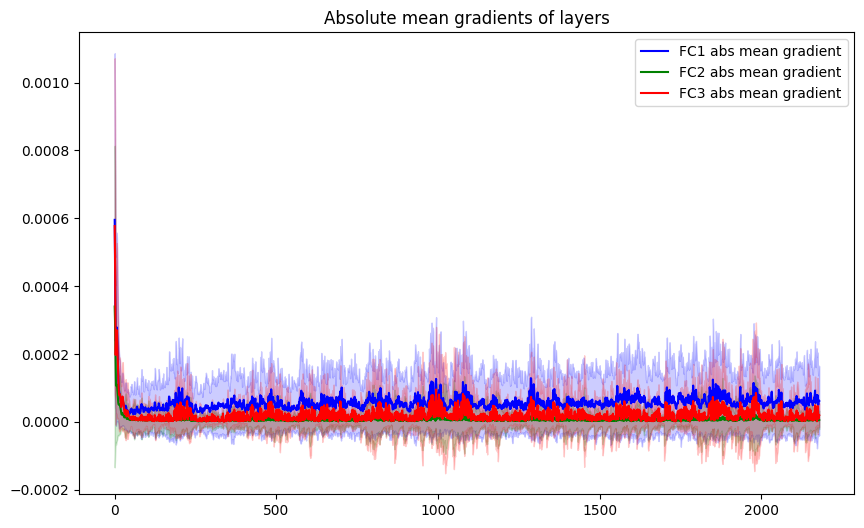

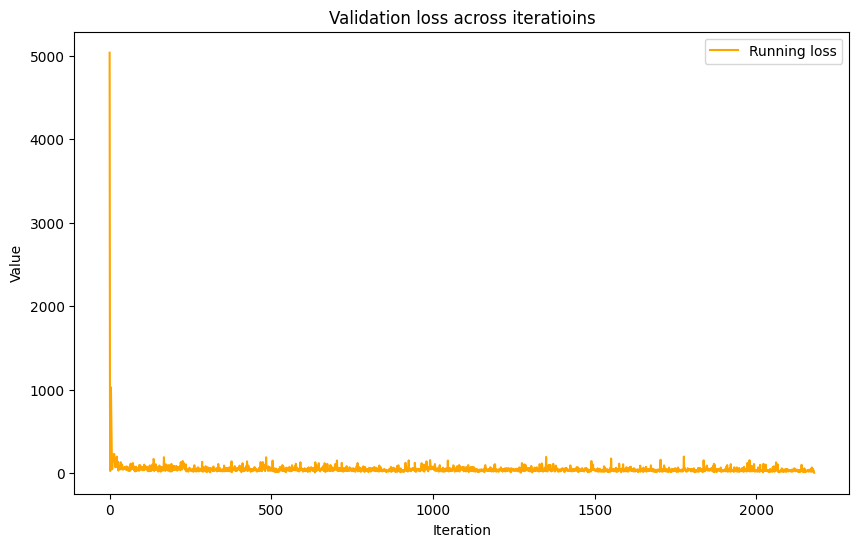

E1/5 S1/436 Loss=47.1652
E1/5 S2/436 Loss=6.3094
E1/5 S3/436 Loss=1.0739
E1/5 S4/436 Loss=9.6131
E1/5 S5/436 Loss=13.2881
E1/5 S6/436 Loss=6.8126
E1/5 S7/436 Loss=2.0427
E1/5 S8/436 Loss=1.2745
E1/5 S9/436 Loss=2.4947
E1/5 S10/436 Loss=4.7905
E1/5 S11/436 Loss=5.4350
E1/5 S12/436 Loss=4.4155
E1/5 S13/436 Loss=2.0720
E1/5 S14/436 Loss=1.2713
E1/5 S15/436 Loss=1.2551
E1/5 S16/436 Loss=0.7526
E1/5 S17/436 Loss=1.4855
E1/5 S18/436 Loss=2.3324
E1/5 S19/436 Loss=1.3186
E1/5 S20/436 Loss=1.3900
E1/5 S21/436 Loss=1.0812
E1/5 S22/436 Loss=1.1490
E1/5 S23/436 Loss=0.7433
E1/5 S24/436 Loss=0.5348
E1/5 S25/436 Loss=0.6045
E1/5 S26/436 Loss=1.0552
E1/5 S27/436 Loss=0.7923
E1/5 S28/436 Loss=1.5615
E1/5 S29/436 Loss=0.7775
E1/5 S30/436 Loss=1.1567
E1/5 S31/436 Loss=0.4364
E1/5 S32/436 Loss=0.6683
E1/5 S33/436 Loss=0.6602
E1/5 S34/436 Loss=0.7058
E1/5 S35/436 Loss=1.2109
E1/5 S36/436 Loss=0.9958
E1/5 S37/436 Loss=0.4284
E1/5 S38/436 Loss=0.7966
E1/5 S39/436 Loss=0.3460
E1/5 S40/436 Loss=0.3092
E1/5 S4

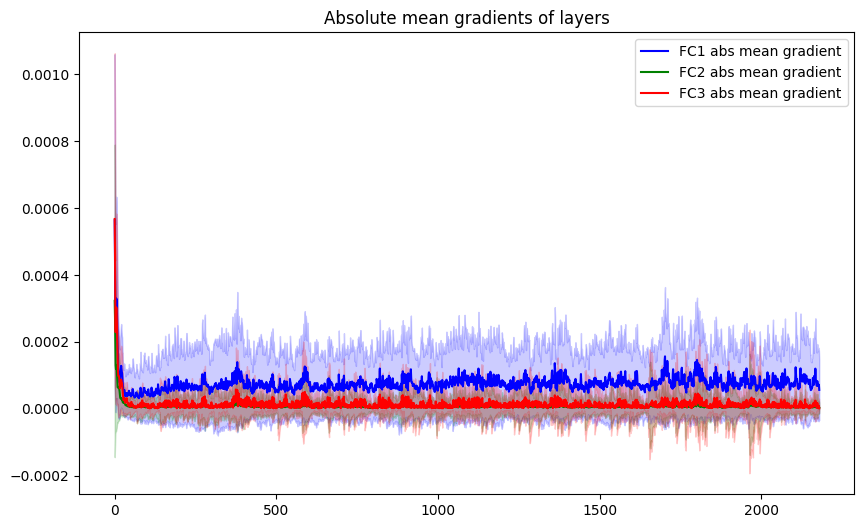

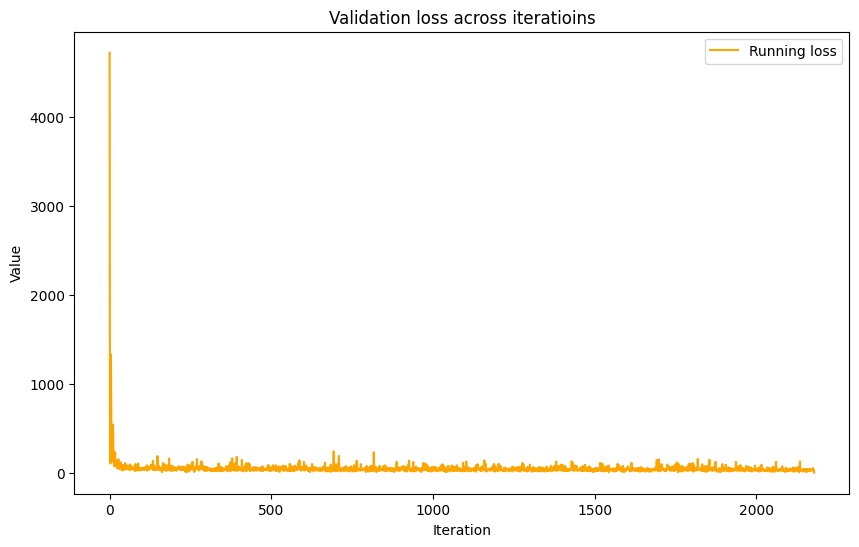

In [62]:
import torch.optim as optim
import matplotlib.pyplot as plt

import torch.nn.init as init

EPOCHS = 5
LEARNING_RATE = 0.001

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def dabs_mean_std(
    tensor1: torch.Tensor,
    tensor2: torch.Tensor
):
    dabs: torch.Tensor = torch.abs(tensor2 - tensor1)

    mean = torch.mean(dabs)
    std = torch.std(dabs)

    return (mean.item(), std.item())

def train(model: RegularNetwork, loader, epochs, criterion, optimizer):
    # Наблюдаемые величины
    running_losses: list[float] = []
    fc1_dabs_mean: list[float] = []
    fc1_dabs_std: list[float] = []
    fc2_dabs_mean: list[float] = []
    fc2_dabs_std: list[float] = []
    fc3_dabs_mean: list[float] = []
    fc3_dabs_std: list[float] = []

    for epoch in range(epochs):
        running_loss = 0.0

        model.train()

        for i, (inputs, labels) in enumerate(loader):
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            fc1_weight = model.fc1.weight.clone()
            fc2_weight = model.fc2.weight.clone()
            fc3_weight = model.fc3.weight.clone()

            optimizer.step()

            running_loss += loss.item()

            #if i % 2 == 1:
            if True:
                (mean1, std1) = (dabs_mean_std(fc1_weight, model.fc1.weight))
                fc1_dabs_mean.append(mean1)
                fc1_dabs_std.append(std1)

                (mean2, std2) = (dabs_mean_std(fc2_weight, model.fc2.weight))
                fc2_dabs_mean.append(mean2)
                fc2_dabs_std.append(std2)

                (mean3, std3) = (dabs_mean_std(fc3_weight, model.fc3.weight))
                fc3_dabs_mean.append(mean3)
                fc3_dabs_std.append(std3)

                print(f'E{epoch + 1}/{epochs} S{i + 1}/{len(loader)} Loss={running_loss / 100:.4f}')
                running_losses.append(running_loss)
                running_loss = 0.0

    X = range(len(fc1_dabs_mean))

    def plot_mean_std(label, color, series_mean, series_std):
        plt.plot(X, series_mean, label=label, color=color)

        plt.fill_between(
            X,
            [m - s for m, s in zip(series_mean, series_std)],
            [m + s for m, s in zip(series_mean, series_std)],
            color=color,
            alpha=0.2
        )

    plt.figure(figsize=(10, 6))
    plot_mean_std('FC1 abs mean gradient', 'blue', fc1_dabs_mean, fc1_dabs_std)
    plot_mean_std('FC2 abs mean gradient', 'green', fc2_dabs_mean, fc2_dabs_std)
    plot_mean_std('FC3 abs mean gradient', 'red', fc3_dabs_mean, fc3_dabs_std)
    plt.title('Absolute mean gradients of layers')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(X, running_losses, label='Running loss', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title('Validation loss across iteratioins')
    plt.legend()
    plt.show()

# For classification
# criterion = nn.CrossEntropyLoss()

# For regression
criterion = nn.MSELoss()

model1 = RegularNetwork(
    inputs_count=dataset.features_count,
    outputs_count=dataset.classes_count
)

model1.apply(init_weights)

train(
    model=model1,
    loader=dataset.train_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optim.Adam(
        model1.parameters(),
        lr=LEARNING_RATE
    )
)

torch.save(model1.state_dict(), 'model1.pth')

model2 = AugmentedNetwork(
    inputs_count=dataset.features_count,
    outputs_count=dataset.classes_count
)

train(
    model=model2,
    loader=dataset.train_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optim.Adam(
        model2.parameters(),
        lr=LEARNING_RATE
    )
)

model2.apply(init_weights)

torch.save(model2.state_dict(), 'model2.pth')



## Валидация

In [78]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, r2_score, mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def positive_probs_from(probs: torch.Tensor) -> list:
    return np.array(probs)[:, 0]

def evaluate_classification_model(
    path: str,
    constructor: type,
    noise_factor: float,
    is_binary_classification: bool,
    inputs_count: int,
    outputs_count: int
):
    evaluated_model = constructor(
        inputs_count=inputs_count,
        outputs_count=outputs_count
    )

    evaluated_model.load_state_dict(torch.load(path))

    evaluated_model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataset.test_loader:
            outputs = evaluated_model(
                inputs + torch.randn(inputs.shape) * noise_factor
            )
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    if is_binary_classification:
        all_probs = np.array(all_probs)[:, 0]

    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    return accuracy, f1, roc_auc

def evaluate_regression_model(
    path: str,
    constructor: type,
    noise_factor: float,
    inputs_count: int,
    outputs_count: int
):
    evaluated_model = constructor(
        inputs_count=inputs_count,
        outputs_count=outputs_count
    )

    evaluated_model.load_state_dict(torch.load(path))

    evaluated_model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataset.test_loader:
            noisy_inputs = inputs + torch.randn(inputs.shape) * noise_factor
            outputs = evaluated_model(noisy_inputs)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    r2 = r2_score(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)

    return r2, mse

def evaluate_model(
    path: str,
    constructor: type,
    is_binary_classification: bool,
    is_regression: bool,
    inputs_count: int,
    outputs_count: int
):
    noise_factors = [
        0, 1, 3, 5, 8,
        10, 30, 50, 60, 70, 80,
        100, 300, 500, 600, 700, 800,
        1000, 3000, 5000,
        10000, 30000, 50000,
    ]

    if is_regression:
        samples = {
            'noise_factor': noise_factors,
            'r2': [],
            'mse': [],
        }

        for noise_factor in noise_factors:
            r2, mse = evaluate_regression_model(
                path=path,
                constructor=constructor,
                noise_factor=noise_factor,
                inputs_count=inputs_count,
                outputs_count=outputs_count,
            )

            samples['r2'].append(r2)
            samples['mse'].append(mse)

        return pd.DataFrame(samples)
    else:
        samples = {
            'noise_factor': noise_factors,
            'accuracy': [],
            'f1': [],
            'roc_auc': [],
        }

        for noise_factor in noise_factors:
            accuracy, f1, roc_auc = evaluate_classification_model(
                path=path,
                constructor=constructor,
                noise_factor=noise_factor,
                is_binary_classification=is_binary_classification,
                inputs_count=inputs_count,
                outputs_count=outputs_count,
            )

            samples['accuracy'].append(accuracy)
            samples['f1'].append(f1)
            samples['roc_auc'].append(roc_auc)

        return pd.DataFrame(samples)

def plot_evaluation_of_classification(df: pd.DataFrame):
    plt.figure(figsize=(10, 6))

    plt.plot(df['noise_factor'], df['accuracy'], label='Accuracy', marker='o')
    plt.plot(df['noise_factor'], df['f1'], label='F1 Score', marker='o')
    plt.plot(df['noise_factor'], df['roc_auc'], label='ROC AUC', marker='o')

    plt.xscale('log')

    plt.xlabel('Noise Factor')
    plt.ylabel('Metric Value')
    plt.title('Metrics vs Noise Factor')
    plt.legend()

    plt.grid(True, which="both", ls="--")
    plt.show()

def plot_evaluation_of_regression(df: pd.DataFrame):
    plt.figure(figsize=(10, 6))

    plt.plot(df['noise_factor'], df['mse'], label='Mean Square Error', marker='o')
    plt.plot(df['noise_factor'], df['r2'], label='R^2', marker='o')

    plt.xscale('log')

    plt.xlabel('Noise Factor')
    plt.ylabel('Metric Value')
    plt.title('Metrics vs Noise Factor')
    plt.legend()

    plt.grid(True, which="both", ls="--")
    plt.show()

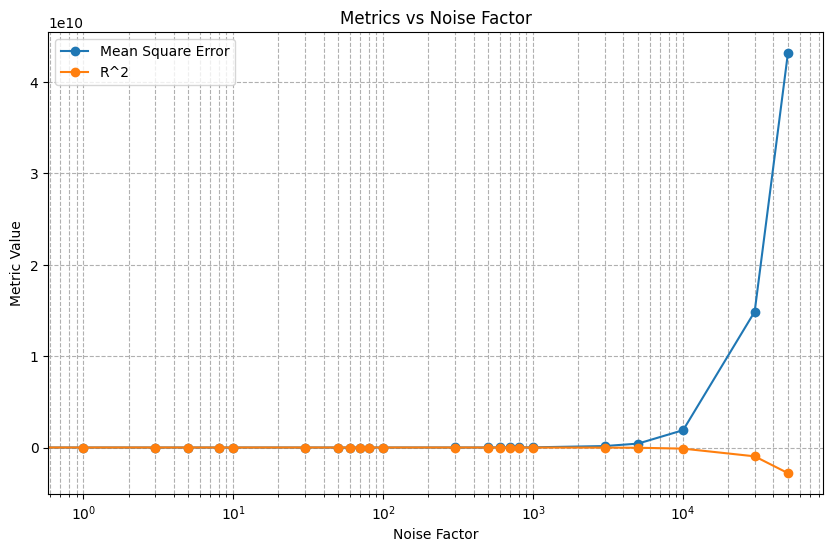

In [79]:
plot_evaluation_of_regression(evaluate_model(
    path='model1.pth',
    constructor=RegularNetwork,
    is_binary_classification=False,
    is_regression=True,
    inputs_count=19,
    outputs_count=1
))
# evaluate_model(
#     path='model1.pth',
#     constructor=RegularNetwork,
#     is_binary_classification=False,
#     is_regression=True,
#     inputs_count=19,
#     outputs_count=1
# )

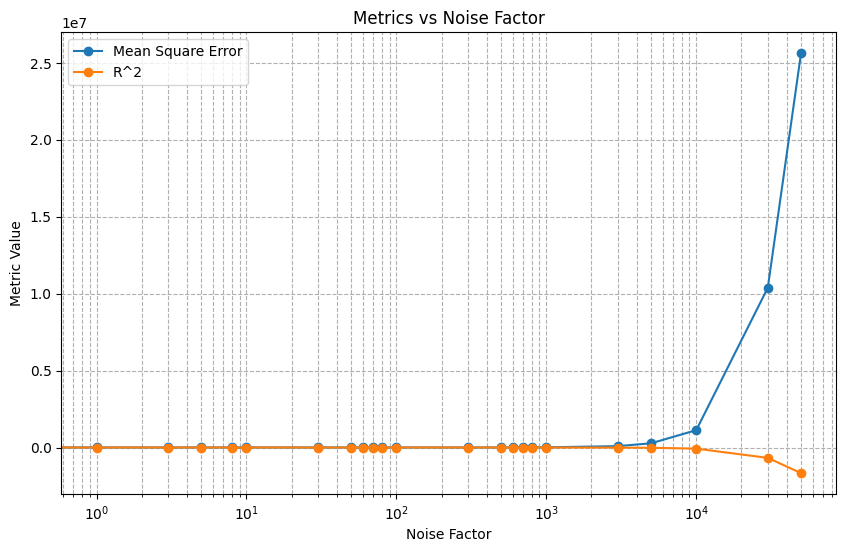

In [80]:
plot_evaluation_of_regression(evaluate_model(
    path='model2.pth',
    constructor=RegularNetwork,
    is_binary_classification=False,
    is_regression=True,
    inputs_count=19,
    outputs_count=1
))